# Initialiazation Packages

In [3]:
#using Pkg; Pkg.build("PyCall")
#using Pkg; Pkg.build("PyPlot")
#using PyCall
#PyCall.python
using PyCall
using PyPlot

In [4]:
using LinearAlgebra
using LaTeXStrings
using QuantumToolbox
using DelimitedFiles, NLsolve
using Random, Distributions, Dates, Polynomials, StatsBase 
using JLD, Roots
using DifferentialEquations

In [5]:
#using Pkg
#Pkg.activate("..")

include("../src/Classical_open_2KPOs_functions.jl")
using .Classical_open_KPOs

#include("../src/Classical_2KPOs_functions.jl")
#import .Classical_KPOs: Weighted_initial_conditions

## Lyapunov exponent of the classical trajectories of the open system

We know that the interaction with the enviroment is going to decrease the Lyapunov of the classical trajectories. The idea is to initialize the trajectories with the same energy as the closed system (x - axis) and calculate the new Lyapunov exponent (y-axis) but now evolved by the open system. 

In [6]:
#KPOs parameters
p = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, γ, κ1, κ2 = 0., 1., 0., 5., 0., 1., 0., 5., 1.0, 0.025, 0.025;
min_ics = 10

10

Generating ICs from Closed system sweeping Energy

In [5]:
function closed_initial_conditions(E, params, q_l, q_r; min_ics=100, max_attempts=1_000_000)
    println("parameters: ", params)
    initial_conditions = Vector{Vector{Float64}}()
    timeout_seconds = 3
    attempts = 0
    start_time = now()
    rng = MersenneTwister(122)

    
    while length(initial_conditions) < min_ics && attempts < max_attempts
        # Check if timeout reached
        
        if Dates.value(now() - start_time) / 1000 > timeout_seconds
            #println("Timeout reached after $(timeout_seconds) seconds. Generated $(length(initial_conditions)) ICs.")
            break
        end
    
        # Random (q1, p1, q2) 
        q1, p1, q2 = rand(rng, Uniform(q_l, q_r)), rand(rng, Uniform(q_l, q_r)), rand(rng, Uniform(q_l, q_r))
        p2s = real_p2_roots(q1,p1,q2,E,params)
        if isempty(p2s)
            continue
        end
        
        for p2 in p2s
            push!(initial_conditions, [q1, p1, q2, p2])
        end    
        attempts += 1
    end
    #println("Generated ", length(initial_conditions), " valid ICs in ", attempts, " attempts.")
    return initial_conditions, weights
end

function real_p2_roots(q1, p1, q2, E, params; imag_tol=1e-6)
    """
        returns real roots of the polynomial a0 + a1 p2 + a2 p2^2 + a3 p2^3 + a4 p2^4 = 0
    """
    a0,a1,a2,a3,a4 = p2_polynomial_coeffs(q1,p1,q2,E,params)
    coeffs = [a0, a1, a2, a3, a4]
    poly = Polynomial(coeffs)   # constant + ... + a4 x^4
    rts = Polynomials.roots(poly)
    realr = Float64[]
    for z in rts
        if abs(imag(z)) <= imag_tol
            push!(realr, real(z))
        end
    end
    return realr
end

    
function p2_polynomial_coeffs(q1, p1, q2, E, params)
    """
        returns coefficients (a0, a1, a2, a3, a4) for polynomial a0 + a1 p2 + a2 p2^2 + a3 p2^3 + a4 p2^4 = 0
    """

    δ1, K1, ξ11, ξ21, δ2, K2, ξ12, ξ22, γ = params

    q1sq = q1^2
    p1sq = p1^2
    q2sq = q2^2

    a4 = K2 / 4.0                        
    a3 = 0.0                             
    a2 = -δ2/2.0 + (K2/2.0)*q2sq + ξ22  
    a1 = -γ * p1                         
    # constant term: H with p2=0 minus E
    a0 = -δ1*(q1sq + p1sq)/2 + K1*((q1sq + p1sq)^2)/4 - sqrt(2)*ξ11*q1 - ξ21*(q1sq - p1sq) -
        δ2*(q2sq)/2 + K2*(q2sq^2)/4 - sqrt(2)*ξ12*q2 - ξ22*(q2sq) - γ*(q1*q2) - E

    return (a0, a1, a2, a3, a4)
end
    


p2_polynomial_coeffs (generic function with 1 method)

In [6]:
E = 10
ICs, ωs = closed_initial_conditions(E, p[1:9], -13., 13., min_ics=min_ics)
println("Initial conditions with Energy $(E)")
display(ICs[1:10])
for i in 1:length(ICs)
    println(H_class(ICs[i], p[1:9]))
end

parameters: (0.0, 1.0, 0.0, 5.0, 0.0, 1.0, 0.0, 5.0, 1.0)
Initial conditions with Energy 10


10-element Vector{Vector{Float64}}:
 [3.092685945194077, 0.18473385897180172, -1.2639385584843126, -2.2990463845672977]
 [3.092685945194077, 0.18473385897180172, -1.2639385584843126, 2.320865058504063]
 [2.4962193634341467, 0.911844906447353, -1.908749326589902, -2.0422236002065226]
 [2.4962193634341467, 0.911844906447353, -1.908749326589902, 2.1433950605756165]
 [-4.078607059723684, -1.3320182329117944, 0.9468028647021214, -0.24216840845637527]
 [-4.078607059723684, -1.3320182329117944, 0.9468028647021214, -0.001662364949186693]
 [-1.5336139543733225, 1.4081763929208613, -0.35348047001852123, -1.1192353380804179]
 [-1.5336139543733225, 1.4081763929208613, -0.35348047001852123, 1.3604300478777465]
 [-1.4242160727081696, -0.04722361725610824, 1.3291882948918268, -1.9289181042724097]
 [-1.4242160727081696, -0.04722361725610824, 1.3291882948918268, 1.9228151716549635]

10.000000000000025
10.00000000000003
10.000000000000021
10.000000000000089
10.0
10.0
10.0
9.99999999999999
10.000000000000004
9.999999999999995


## Calcualting the Lyapunov Exponent for the ICs for the closed system

In [7]:
function EqM_closed!(du, u, parameters, t)
    @inbounds begin
        q1, p1, q2, p2 = u
        δ1, K1, ξ11, ξ21, δ2, K2, ξ12, ξ22, γ = parameters

        # Precompute reusable terms
        q1_sq, p1_sq, q2_sq, p2_sq = q1^2, p1^2, q2^2, p2^2
        sum1 = K1 * (p1_sq + q1_sq)
        sum2 = K2 * (p2_sq + q2_sq)

        # Equations of motion
        du[1] = (-δ1 + 2 * ξ21 + sum1) * p1 - γ * p2
        du[2] = (δ1 + 2 * ξ21 - sum1) * q1 + γ * q2 + sqrt(2)*ξ11
        du[3] = (-δ2 + 2 * ξ22 + sum2) * p2 - γ * p1
        du[4] = (δ2 + 2 * ξ22 - sum2) * q2 + γ * q1 + sqrt(2)*ξ12
    end
    return nothing
end

function Jacobian_qp_closed(u::Vector{Float64},p::Tuple{Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,})
    @inbounds begin
    q1, p1, q2, p2 = u
    δ1, K1, ξ11, ξ21, δ2, K2, ξ12, ξ22, γ = p
    
    # Precompute reusable terms
    p1_sq, q1_sq = p1^2, q1^2
    p2_sq, q2_sq = p2^2, q2^2

    matrix = zeros(4,4)
    matrix[1,1] = 2*K1*q1*p1; matrix[1,2] = -δ1 + 2*ξ21 + 3*K1*p1_sq + K1*q1_sq; matrix[1,3]=0.; matrix[1,4] = -γ
    matrix[2,1] = δ1 + 2*ξ21 - K1*p1_sq - 3*K1*q1_sq; matrix[2,2] = -2*K1*p1*q1; matrix[2,3]=γ; matrix[2,4] = 0.
    matrix[3,1] = 0.; matrix[3,2] = -γ; matrix[3,3]=2*K2*p2*q2; matrix[3,4] = -δ2 + 2*ξ22 + K2*q2_sq + 3*K2*p2_sq
    matrix[4,1] = γ; matrix[4,2] = 0.; matrix[4,3]= δ2 + 2*ξ22 - 3*K2*q2_sq - K2*p2_sq; matrix[4,4] = -2*K2*p2*q2
    end
    return matrix
end

#function vector to do a evolution like the 
function G_evolution_closed!(dG,G, J,t)
    @inbounds begin
    mul!(dG, J, G)  # In-place multiplication
    end
    nothing
end

function Lyapunov_max_closed(u_i::Vector{Float64}, p::Tuple{Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,}, N::Int64, Δt::Float64,err::Float64)
    @inbounds begin
        prob = ODEProblem(EqM_closed!, u_i, (0.0, N*Δt),saveat = Δt, p)
        # Solve the problem
        sol = solve(prob, Tsit5(), abstol=1e-10, reltol=1e-10, maxiters=N*1000)
        traj = sol.u
        
        #Defining the matrix for ICs vectors
        G = Matrix{Float64}(I, 4, 4)
        λ = zeros(4)
        λ1 = zeros(4)
        λ_t = zeros(N)

        for i in 1:Int(N)
            x = traj[i]
            
            J = Jacobian_qp_closed(x,p)
            #Evolution of G from J 

            prob = ODEProblem(G_evolution_closed!, G, (0.0, Δt), J)
            
            sol = solve(prob,Tsit5(),save_everystep = false,abstol=err, reltol=err)
            G = sol.u[end]
            
            G,R = GS(G)
            if i*Δt > 100
                λ += log.((diag(R)))
            end
            λ1 += log.((diag(R)))
            λ_t[i] = maximum(λ1)/(i*Δt)
            
        end
    end
    #println(time()-t)
    T = (N - 100/Δt)Δt
    λ = λ/(T)

    λ_max = maximum(λ)
    return λ_max, λ_t
end


Lyapunov_max_closed (generic function with 1 method)

In [8]:
N = Int(2e5) #number of time steps for the Lyapunov calculation
Δt = 1e-3 #smallest time inteval for the Lapunov calculation
err= 1e-3 #tolerance for the Lyapunov calculation
λs = zeros(length(ICs))

for i in 1:length(ICs)
    λ_max, λ_t = Lyapunov_max_closed(ICs[i], p[1:9], N, Δt, err)
    println("Lyapunov exponent for IC $(i): $(λ_max)")
    λs[i] = λ_max
end

Lyapunov exponent for IC 1: 0.0758896331684483
Lyapunov exponent for IC 2: 0.04927632631875011
Lyapunov exponent for IC 3: 2.2948775331380826
Lyapunov exponent for IC 4: 0.10555425256437831
Lyapunov exponent for IC 5: 2.1344172068269107
Lyapunov exponent for IC 6: 1.9545541575113663
Lyapunov exponent for IC 7: 2.305051443725114
Lyapunov exponent for IC 8: 2.4201395718017893
Lyapunov exponent for IC 9: 2.1457574778602666
Lyapunov exponent for IC 10: 2.555906800144656


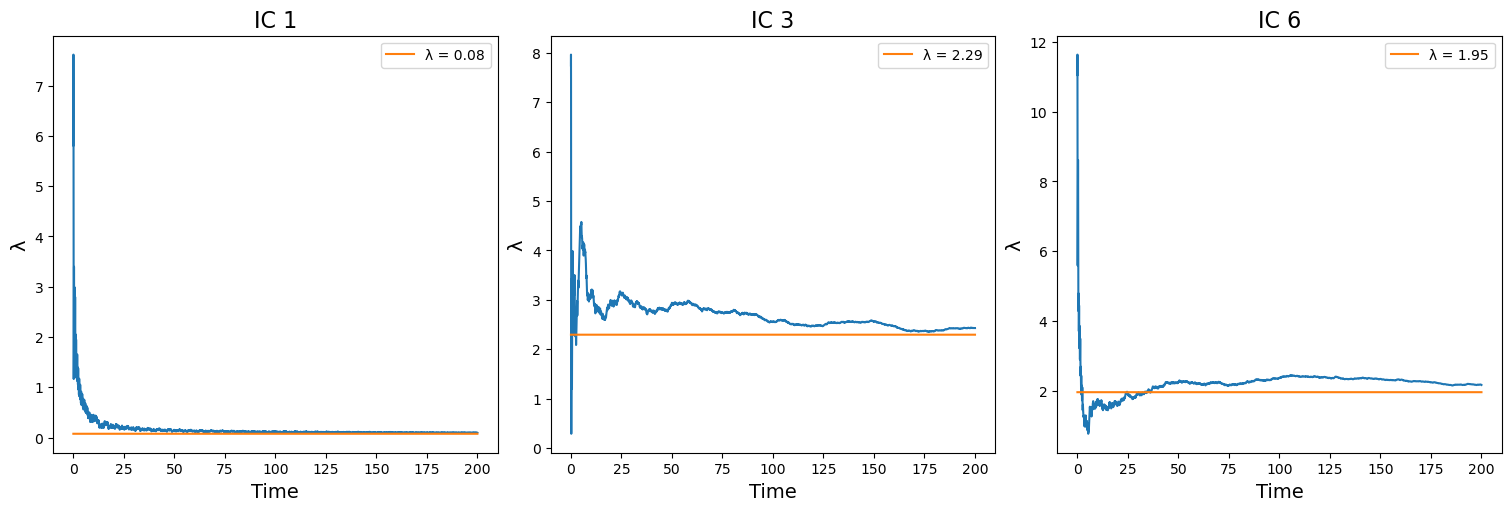

In [9]:
fig = figure(figsize=(15,5), layout= "constrained")
gs = fig.add_gridspec(1,3)
element(i,j) = get(gs, (i,j)) # starts at 0 to N-1
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j)

ICs_sel = [1,3,6]
for i in 1:length(ICs_sel)
    ax = fig.add_subplot(element(0,i-1))
    IC_sel = ICs_sel[i]
    λ_max, λ_t = Lyapunov_max_closed(ICs[IC_sel], p[1:9], N, Δt, err)
    plot(range(0, N*Δt, length=N), λ_t, "-")
    plot(range(0, N*Δt, length=N), range(λ_max,λ_max, length=N), "-", label="λ = $(round(λ_max, digits=2))")
    xlabel("Time", fontsize=14)
    ylabel("λ", fontsize=14)
    title("IC $(IC_sel)", fontsize=16)
    legend()
end

## Benchmarking the Lyapunov Exponent using the same ICs for the open system but kappa = 0

In [10]:
N = Int(2e5) #number of time steps for the Lyapunov calculation
Δt = 1e-3 #smallest time inteval for the Lapunov calculation
err= 1e-3 #tolerance for the Lyapunov calculation
λs = zeros(length(ICs))
p_0 = 0., 1., 0., 5., 0., 1., 0., 5., 1.0, 0., 0.;

for i in 1:length(ICs)
    λ_max, λ_t = Lyapunov_max(ICs[i], p_0, N, Δt, err)
    println("Lyapunov exponent for IC $(i): $(λ_max)")
    λs[i] = λ_max
end

Lyapunov exponent for IC 1: 0.0758896331684483
Lyapunov exponent for IC 2: 0.04927632631875011
Lyapunov exponent for IC 3: 2.2948775331380826
Lyapunov exponent for IC 4: 0.10555425256437831
Lyapunov exponent for IC 5: 2.1344172068269107
Lyapunov exponent for IC 6: 1.9545541575113663
Lyapunov exponent for IC 7: 2.305051443725114
Lyapunov exponent for IC 8: 2.4201395718017893
Lyapunov exponent for IC 9: 2.1457574778602666
Lyapunov exponent for IC 10: 2.555906800144656


It looks good!

## Lyapunov Exponent for the ICs for the open system for kappa $\neq$ 0

In [11]:
N = Int(2e5) #number of time steps for the Lyapunov calculation
Δt = 1e-3 #smallest time inteval for the Lapunov calculation
err= 1e-3 #tolerance for the Lyapunov calculation
λs = zeros(length(ICs))

for i in 1:length(ICs)
    λ_max, λ_t = Lyapunov_max(ICs[i], p, N, Δt, err)
    println("Lyapunov exponent for IC $(i): $(λ_max)")
    λs[i] = λ_max
end

Lyapunov exponent for IC 1: -0.007470090974578268
Lyapunov exponent for IC 2: -0.008979276302042047
Lyapunov exponent for IC 3: -0.009321811561163995
Lyapunov exponent for IC 4: -0.006010765179299377
Lyapunov exponent for IC 5: -0.008789300917799989
Lyapunov exponent for IC 6: -0.009899461887968912
Lyapunov exponent for IC 7: -0.010443009885832723
Lyapunov exponent for IC 8: -0.006740998494245647
Lyapunov exponent for IC 9: -0.006831617239981839
Lyapunov exponent for IC 10: -0.008016399487864256


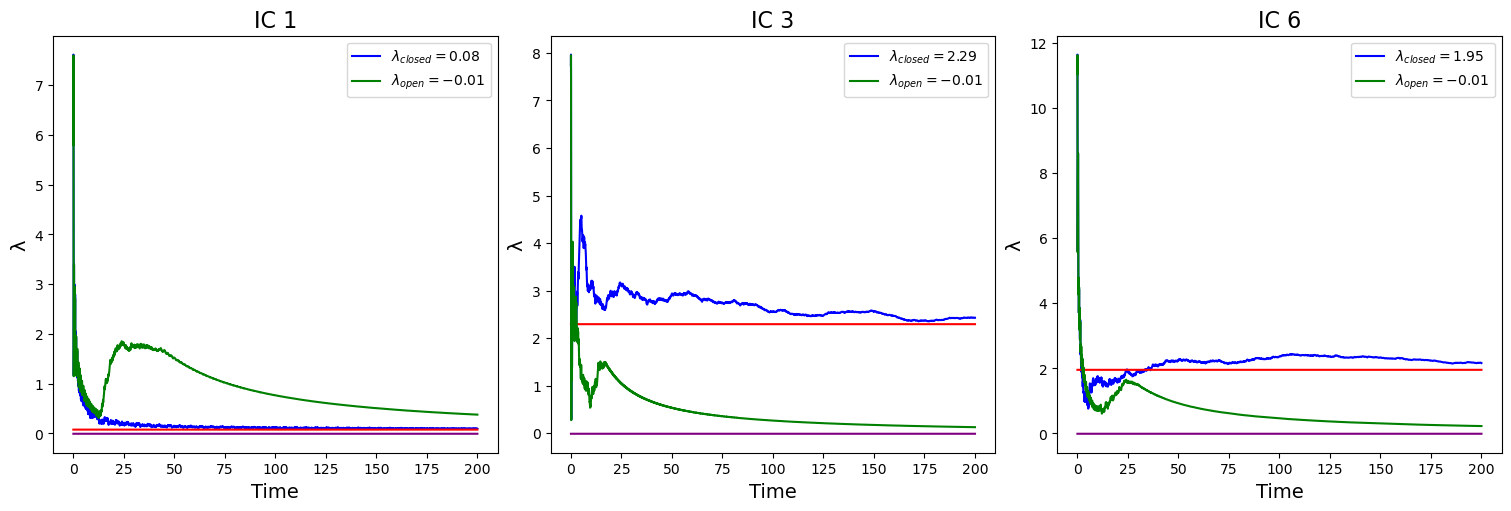

In [12]:
fig = figure(figsize=(15,5), layout= "constrained")
gs = fig.add_gridspec(1,3)
element(i,j) = get(gs, (i,j)) # starts at 0 to N-1
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j)

ICs_sel = [1,3,6]
for i in 1:length(ICs_sel)
    ax = fig.add_subplot(element(0,i-1))
    IC_sel = ICs_sel[i]
    λ_max, λ_t = Lyapunov_max_closed(ICs[IC_sel], p[1:9], N, Δt, err)
    plot(range(0, N*Δt, length=N), λ_t, "-", label=L"λ_{closed} = %$(round(λ_max, digits=2))", color="blue")
    plot(range(0, N*Δt, length=N), range(λ_max,λ_max, length=N), "-", color="red")
    
    λ_max, λ_t = Lyapunov_max(ICs[IC_sel], p, N, Δt, err)
    plot(range(0, N*Δt, length=N), λ_t, "-", label=L"λ_{open} = %$(round(λ_max, digits=2))", color="green")
    plot(range(0, N*Δt, length=N), range(λ_max,λ_max, length=N), "-", color="purple")
    xlabel("Time", fontsize=14)
    ylabel("λ", fontsize=14)
    title("IC $(IC_sel)", fontsize=16)
    legend()
end

### HPC results

#### Treating data from Slurm

In [7]:
#Treating data 
Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, κ1, κ2 =  0., 1., 0., 5., 0., 1., 0., 5., 0.025, 0.025;
ps = [0.1, 1., 5.]
ICs = 100

#roots, cE, λs_p31, s_λ = crit_energies(p);
n_E = 300
#Es1 = range(cE[1],600+cE[1], length=n_E)
#println( cE[1] )
#Energies = Es1 .- cE[1] 

#Non-existing data
λs = [Float64[] for i in 1:n_E]
#existing data
#λs = load("../data/Lyapunov_open/Lyapunov_Energies_$(p)_ICs_$(ICs)_open.jld")["λs"] 

data_miss= []
j=3
p = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, ps[j], κ1, κ2;
for job in 1:12
    try
        λs[(25*(job-1) + 1):25*job] = load("../data/Lyapunov_open/Lyapunov_Energies_$(p)_job_$(job)_ICs_$(ICs)_open.jld")["λs"][(25*(job-1) + 1):25*job]
    catch
        #println("Missing job $(job)")
        push!(data_miss, job)
    end    
end
println("γ = $(ps[j])")
println("data_miss = $(data_miss)")
#Just uncomment to save data
#save("../data/Lyapunov_open/Lyapunov_Energies_$(p)_ICs_$(ICs)_open.jld", "λs", λs) 

#testing
#λs = load("../data/Lyapunov_open/Lyapunov_Energies_$(p)_ICs_$(ICs)_open.jld")["λs"] 

γ = 5.0
data_miss = Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


### Plotting HPC data

-51.00492109374969
γ = 0.1
-60.49991406249748
γ = 1.0
-112.49988281248473
γ = 5.0


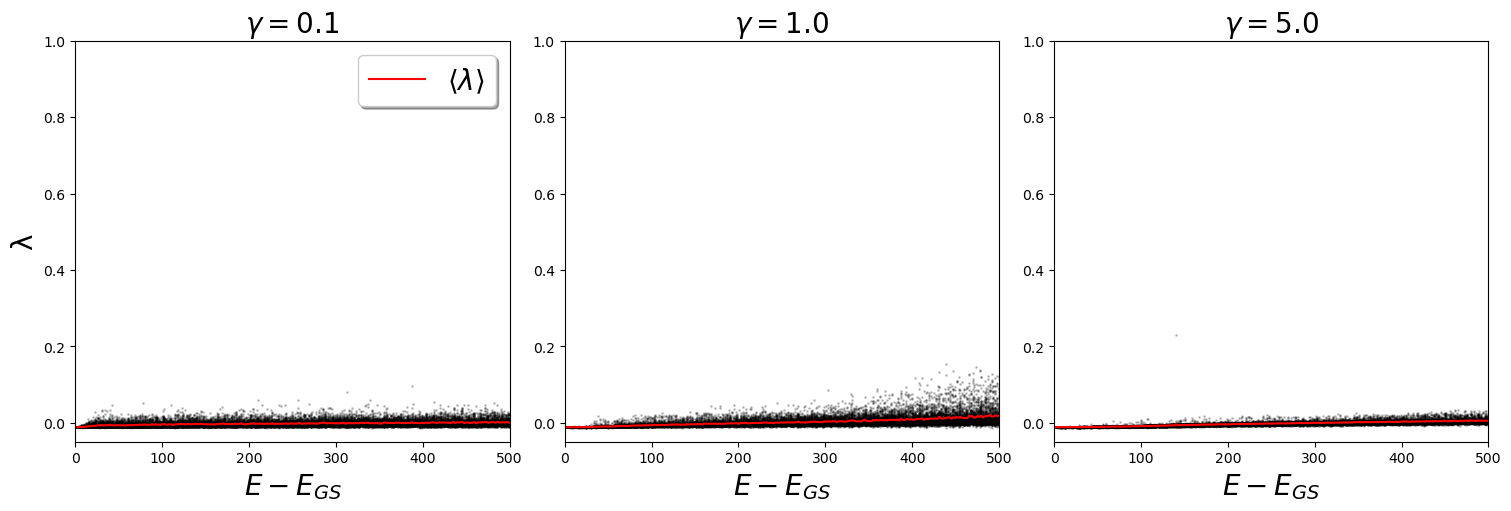

In [8]:
fig = figure(figsize=(15,5), layout= "constrained")
gs = fig.add_gridspec(1,3)
element(i,j) = get(gs, (i,j)) # starts at 0 to N-1
slice(i,j) = pycall(pybuiltin("slice"), PyObject, i,j)
colors_ = ["red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"];
markers_ = ["o", "v", "s", "D", "^", "<", ">", "p", "*", "h"];
xx_lim = 500
font_label = 20


Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, κ1, κ2 =  0., 1., 0., 5., 0., 1., 0., 5., 0.025, 0.025;
ps = [0.1, 1., 5.]
ICs = 100


#Lyapunov exponent
#Lyapunov exponent
for j in 1:3
    ax = fig.add_subplot(element(0,j-1))
    p = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, ps[j], κ1, κ2;

    roots, cE, λs_p31, s_λ = closed_crit_energies(p,6);
    n_E = 300
    Es1 = range(cE[1],600+cE[1], length=n_E)
    println( cE[1] )
    Energies = Es1 .- cE[1] 
    λ_mean = zeros(n_E)
    λs= load("../data/Lyapunov_open/Lyapunov_Energies_$(p)_ICs_$(ICs)_open.jld")["λs"] 
    println("γ = $(ps[j])")
    
    
    
    for i in 1:length(λs)
        scatter(range(Energies[i], Energies[i], length=length(λs[i])), λs[i], color="black", alpha=0.2,s=1);
        λ_mean[i] = mean(λs[i])
    end

    plot(Energies, λ_mean, "-", color="red", markersize=5, label = L"⟨λ⟩");
    title(L"γ = %$(ps[j])", fontsize=font_label)
    #ax.text(.03, 0.85, L"γ = %$(ps[j])", transform=ax.transAxes, fontsize=20, verticalalignment="top")
    if j ==1
        legend(fontsize=20, shadow=true, loc = "upper right");
    end

    if j ==1
        ylabel("λ", fontsize = font_label)
        #yticks([0, 4, 8], fontsize=15)
        #xlim(0, 130)
        #ylim(-.05, 3.5)
    else
        #yticks([])
    end
    xlim(-0.05, xx_lim)
    ylim(-.05, 1.0)
    xlabel(L"E - E_{GS}", fontsize = font_label)
end



In [ ]:
# Single subplot for gamma = 1 (middle panel)
fig = figure(figsize=(6,5), layout="constrained")
ax = fig.add_subplot(1,1,1)
colors_ = ["red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"];
markers_ = ["o", "v", "s", "D", "^", "<", ">", "p", "*", "h"];
xx_lim = 500
font_label = 20

Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, κ1, κ2 =  0., 1., 0., 5., 0., 1., 0., 5., 0.025, 0.025;
ps = [0.1, 1., 5.]
ICs = 100

j = 2  # gamma = 1.0
p = Δ1, K1, ξ11, ξ21, Δ2, K2, ξ12, ξ22, ps[j], κ1, κ2;

roots, cE,  λs_p31, s_λ = closed_crit_energies(p,6);
n_E = 300
Es1 = range(cE[1],600+cE[1], length=n_E)
println( cE[1] )
Energies = Es1 .- cE[1] 
λ_mean = zeros(n_E)
λs= load("../data/Lyapunov_open/Lyapunov_Energies_$(p)_ICs_$(ICs)_open.jld")["λs"] 
println("γ = $(ps[j])")

for i in 1:length(λs)
    scatter(range(Energies[i], Energies[i], length=length(λs[i])), λs[i], color="black", alpha=0.2,s=1);
    λ_mean[i] = mean(λs[i])
end

plot(Energies, λ_mean, "-", color="red", markersize=5, label = L"⟨λ⟩");
title(L"γ = %$(ps[j])", fontsize=font_label)
legend(fontsize=20, shadow=true, loc = "upper right");
ylabel("λ", fontsize = font_label)
xlim(-0.05, xx_lim)
ylim(-.05, 0.2)
xlabel(L"E - E_{GS}", fontsize = font_label)
